In [37]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from tpot import TPOTClassifier

In [38]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [39]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")
data['Source'] = 'Original'

In [40]:
X = data[features_num]
y = data[[y_column, 'Source', 'Xray', 'Opt_spec', 'IRAGN', 'Donley']]

In [41]:
le = LabelEncoder()
labels = np.unique(y["Classification"].astype(str))
y["Classification"] = le.fit_transform(y["Classification"])

/var/lib/condor/execute/dir_2982445/ipykernel_2982501/2943677748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Classification"] = le.fit_transform(y["Classification"])


In [42]:
# -1 in the LOFAR deep fields should become nans since they are factually nans
for c in ['Xray', 'Opt_spec', 'IRAGN', 'Donley']:
    y[c][y[c]==-1]=np.nan
    y[c][y[c] == 1] = True
    y[c][y[c] == 0] = False

/var/lib/condor/execute/dir_2982445/ipykernel_2982501/975002904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[c][y[c]==-1]=np.nan
/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/var/lib/condor/execute/dir_2982445/ipykernel_2982501/975002904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

## BH data

In [43]:
Best_Heckman_data = pd.read_csv("../../../Data/Best&Heckman/BestHeckman+SDSS+wise+LOFAR_better.csv")
Best_Heckman_data['Source'] = 'BH'

In [44]:
# Only selecting data with a classification
Best_Heckman_data = Best_Heckman_data[Best_Heckman_data['Classification'] != 'Radio-loud AGN'] 

In [45]:
Best_Heckman_X = Best_Heckman_data[[c for c in Best_Heckman_data.columns if c != 'Classification']]
Best_Heckman_y = Best_Heckman_data[['Classification', 'Source']]

In [46]:
Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])

/var/lib/condor/execute/dir_2982445/ipykernel_2982501/4234724966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])


In [47]:
y = pd.concat([y, Best_Heckman_y]).reset_index(drop=True)

In [48]:
Best_Heckman_X = Best_Heckman_X[['Z_BEST', 'u_flux_corr',
       'g_flux_corr', 'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'Ks_flux_corr', 'Peak_flux', 'Total_flux']]

# Adding nans to missing columns
Best_Heckman_X[['NUV_flux_corr', 'Bw_flux_corr', 'y_flux_corr', 'K_flux_corr', 
                'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
                'F_SPIRE_500', 'nb921_hsc_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr']] = np.nan

In [49]:
X = pd.concat([X, Best_Heckman_X]).reset_index(drop=True)

### MIGHTEE data

In [50]:
mightee_data = pd.read_csv("../../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")
mightee_data['Source'] = 'MIGHTEE'

In [51]:
# Dropping nan classifications
mightee_data = mightee_data[mightee_data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(mightee_data))

Amount of rows: 4370


In [52]:
mightee_X = mightee_data[[c for c in mightee_data.columns if c != 'Classification']]
mightee_y = mightee_data[['Classification', 'Source', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']]

In [53]:
mightee_y['Classification'] = le.transform(mightee_y['Classification'])
y = pd.concat([y, mightee_y]).reset_index(drop=True)

/var/lib/condor/execute/dir_2982445/ipykernel_2982501/4111256676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mightee_y['Classification'] = le.transform(mightee_y['Classification'])


In [54]:
mightee_X = mightee_X[['Z_BEST', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160',
       'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500', 'Ks_flux_corr',
       'H_flux_corr', 'J_flux_corr', 'i_flux_corr', 'r_flux_corr',
       'u_flux_corr', 'z_flux_corr', 'y_flux_corr', 'NUV_flux_corr',
       #'FUV_flux_corr', 
                       'Total_flux', 'Peak_flux']]

mightee_X[['I_flux_corr', 'R_flux_corr']] = mightee_X[['i_flux_corr', 'r_flux_corr']]
mightee_X = mightee_X.drop(columns=['i_flux_corr', 'r_flux_corr'])

# Adding nans to missing columns
mightee_X[['Bw_flux_corr', 'K_flux_corr', 'g_flux_corr', 'nb921_hsc_flux_corr']] = np.nan

# Changing order
mightee_X = mightee_X[['Total_flux', 'Peak_flux', 
                       'NUV_flux_corr', 'u_flux_corr', 
                       'Bw_flux_corr', 'R_flux_corr', 
                       'I_flux_corr', 'z_flux_corr', 
                       'y_flux_corr', 'J_flux_corr', 
                       'H_flux_corr', 'K_flux_corr', 
                       'Ks_flux_corr', 'ch1_flux_corr', 
                       'ch2_flux_corr', 'ch3_flux_corr', 
                       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 
                       'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350', 
                       'F_SPIRE_500', 'Z_BEST', 
                       'g_flux_corr', 'nb921_hsc_flux_corr']]

In [55]:
X = pd.concat([X, mightee_X]).reset_index(drop=True)

### Generate more features

In [56]:
X['ch1/ch2'] = X['ch1_flux_corr']/X['ch2_flux_corr']
X['ch2/ch3'] = X['ch2_flux_corr']/X['ch3_flux_corr']
X['ch3/ch4'] = X['ch3_flux_corr']/X['ch4_flux_corr']
X['ch3/ch4'] = X['ch3_flux_corr']/X['ch4_flux_corr']
X['r/J'] = X['R_flux_corr']/X['J_flux_corr']
X['u/r'] = X['u_flux_corr']/X['R_flux_corr']
X['g/r'] = X['g_flux_corr']/X['R_flux_corr']

### Bayesian optimisation

In [28]:
from bayes_opt import BayesianOptimization

In [29]:
def optimise_xgboost(max_depth, 
                     reg_alpha, 
                     reg_lambda, 
                     min_child_weight, 
                     eta,
                     max_delta_step,
                     n_estimators):
    # The algorithm gives floats, so we round them
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    
    model = XGBClassifier(use_label_encoder=False, 
                      max_depth=max_depth, 
                      reg_alpha=reg_alpha,   
                      min_child_weight=min_child_weight, 
                      reg_lambda=reg_lambda,
                      max_delta_step=max_delta_step,
                      eta=eta,
                      tree_method='hist',
                      #gpu_id=0,
                      objective='multi:softprob',
                      eval_metric =['merror'],
                      nthread=8,
                      n_estimators=n_estimators
                      )
    
    y_preds = []
    for train_index, val_index in skf.split(X_train, y_train):    
        # Splitting up the new train and test set (from the original train set)
        X_train_cv, X_val = X_train[train_index], X_train[val_index]
        y_train_cv, y_val = y_train[train_index], y_train[val_index]

        # Training the model, no early stopping
        model.fit(X_train_cv, y_train_cv, 
                    verbose=False, 
                   )

        # Getting the accuracy and appending
        y_pred = model.predict(X_val)
        y_preds.append(accuracy_score(y_val, y_pred))
    return np.mean(y_preds)

In [30]:
# Bounded region of parameter space
pbounds = {
    'max_depth': (5, 20),
    'reg_alpha': (0, 5),
    'reg_lambda': (0, 10),
    'min_child_weight': (0, 5),
    'eta': (0.05, 0.6),
    'max_delta_step': (0,10),
    'n_estimators': (10,1000)
}

In [22]:
from sklearn.model_selection import StratifiedKFold

# Getting k folds for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

skf = StratifiedKFold(n_splits=8)

# Needed for cv
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

print(skf)

StratifiedKFold(n_splits=8, random_state=None, shuffle=False)


In [32]:
optimizer = BayesianOptimization(
    f=optimise_xgboost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    optimizer.maximize(
        init_points=5,
        n_iter=100,
    )

|   iter    |  target   |    eta    | max_de... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.8952    | 0.256     | 9.507     | 15.98     | 2.993     | 164.5     | 0.78      | 0.5808    |
| 2         | 0.8941    | 0.5264    | 6.011     | 15.62     | 0.1029    | 970.2     | 4.162     | 2.123     |
| 3         | 0.898     | 0.15      | 1.834     | 9.564     | 2.624     | 437.6     | 1.456     | 6.119     |
| 4         | 0.8977    | 0.1267    | 2.921     | 10.5      | 2.28      | 787.3     | 0.9984    | 5.142     |
| 5         | 0.8958    | 0.3758    | 0.4645    | 14.11     | 0.8526    | 74.4      | 4.744     | 9.656     |
| 6         | 0.8964    | 0.4141    | 6.536     | 13.48     | 4.212     | 446.5     | 4.024     | 7.866     |
| 7         | 0.896     | 0.5692    | 3.268     | 10.08     | 1.197     | 437.0     | 2.364     | 5.719     |
| 8       

| 45        | 0.8966    | 0.5685    | 6.449     | 5.175     | 3.693     | 942.2     | 3.034     | 5.716     |
| 46        | 0.8972    | 0.3       | 2.126     | 5.41      | 3.294     | 294.6     | 3.674     | 9.196     |
| 47        | 0.8971    | 0.2476    | 5.802     | 16.56     | 1.078     | 971.8     | 1.96      | 6.533     |
| 48        | 0.8956    | 0.5384    | 9.301     | 13.43     | 4.547     | 718.6     | 0.3897    | 1.942     |
| 49        | 0.8974    | 0.1097    | 7.182     | 14.1      | 4.441     | 446.6     | 2.819     | 8.214     |
| 50        | 0.8975    | 0.5415    | 1.162     | 9.901     | 1.405     | 449.6     | 4.022     | 6.818     |
| 51        | 0.8973    | 0.2589    | 7.704     | 18.69     | 2.891     | 660.1     | 2.17      | 9.075     |
| 52        | 0.8977    | 0.3381    | 2.609     | 11.07     | 2.476     | 437.0     | 0.622     | 5.295     |
| 53        | 0.8982    | 0.3603    | 3.375     | 9.758     | 3.102     | 436.7     | 0.9107    | 6.555     |
| 54      

## Best model

In [66]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=8, 
                      reg_alpha=4.389,   
                      min_child_weight=0.3662, 
                      reg_lambda=8.856,
                      max_delta_step=9.844,
                      eta=0.08451,
                      tree_method='hist',
                      #gpu_id=0,
                      objective='multi:softprob',
                      eval_metric=['mlogloss', 'merror'],
                      nthread=16,
                      n_estimators=991,
                      random_state=42
                      )

#### Cross-validation

In [67]:
scores_subgroups = pd.DataFrame(columns=['Source', 'Accuracy', 'Precision', 'Recall', 'F1', 'Ratio'])
detection_sources = pd.DataFrame(columns=['Xray', 'Opt_spec',
       'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])
non_detection_sources = pd.DataFrame(columns=['Xray', 'Opt_spec',
       'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

In [68]:
# We need to do a hacky trick so we can stratify over both columns
y['Combined'] = y['Classification'].astype(str) + y['Source'].astype(str)

In [69]:
# Important note here: the splitting is done in such a way that class balance AND source balance is maintained
# See y.value_counts
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y[['Source', 'Classification']], random_state=42)

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

n = 16
skf = StratifiedKFold(n_splits=n)

precisions = []
recalls = []
f1s = []
accuracies = []

# Confusion matrices
cm_all = []
cm_original = []
cm_BH = []
cm_MIGHTEE = []

# Training history data
training_histories = []

i = 0
# Important note here: the stratified k-fold is done in such a way that class balance AND source balance is maintained
# See y_train.value_counts

# We also need to convert y_train in the split to labels, but that is easily done with a label encoder
for train_index, test_index in skf.split(X_train, y_train['Combined']):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    eval_set = [(X_train_cv, y_train_cv['Classification']), (X_test_cv, y_test_cv['Classification'])]
    model.fit(X_train_cv, y_train_cv['Classification'], verbose=False, eval_set=eval_set)
    
    # Model training history
    results = model.evals_result()
    training_histories.append(results)

    y_pred = model.predict(X_test_cv)
    
    # Confusion matrix
    cm = confusion_matrix(y_test_cv['Classification'], y_pred)
    cm_all.append(cm)
    
    # Class-specific scores
    precision = precision_score(y_test_cv['Classification'], y_pred, average=None, labels=[0, 1, 2, 3])
    recall = recall_score(y_test_cv['Classification'], y_pred, average=None, labels=[0, 1, 2, 3])
    f1 = f1_score(y_test_cv['Classification'], y_pred, average=None, labels=[0, 1, 2, 3])
    
    # General scores
    accuracy = accuracy_score(y_test_cv['Classification'], y_pred)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    accuracies.append(accuracy)
    
    # New row for the (non-)detections dataframe, this is essentially a confusion matrix
    cm_row = []
    for detection in ['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']:
        sub_x_test = X_test_cv[y_test_cv[detection] == True]
        sub_y_test = y_test_cv[y_test_cv[detection] == True]
        
        y_pred = model.predict(sub_x_test)
        
        
        cm = confusion_matrix(sub_y_test['Classification'], y_pred, labels=[0, 1, 2, 3])
        cm_row.append(cm)

    newrow = pd.DataFrame(data=[cm_row], 
                          columns=['Xray', 'Opt_spec', 
                                   'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

    detection_sources = pd.concat([detection_sources, newrow], ignore_index=True)
    
    cm_row = []
    for detection in ['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']:
        sub_x_test = X_test_cv[y_test_cv[detection] == False]
        sub_y_test = y_test_cv[y_test_cv[detection] == False]
        
        y_pred = model.predict(sub_x_test)
        
        
        cm = confusion_matrix(sub_y_test['Classification'], y_pred, labels=[0, 1, 2, 3])
        cm_row.append(cm)

    newrow = pd.DataFrame(data=[cm_row], 
                          columns=['Xray', 'Opt_spec', 
                                   'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

    non_detection_sources = pd.concat([non_detection_sources, newrow], ignore_index=True)
    
    # Scores in subgroups
    for source in ['Original', 'BH', 'MIGHTEE']:      
        # Finding the subgroups
        sub_x_test = X_test_cv[y_test_cv['Source'] == source]
        sub_y_test = y_test_cv[y_test_cv['Source'] == source]
        
        y_pred = model.predict(sub_x_test)
        
        # Confusion matrix
        cm = confusion_matrix(sub_y_test['Classification'], y_pred)
        if source == 'Original':
            cm_original.append(cm)
        elif source == 'BH':
            cm_BH.append(cm)
        elif source == 'MIGHTEE':
            cm_MIGHTEE.append(cm)
        
        # Class-specific scores
        precision = precision_score(sub_y_test['Classification'], y_pred, average=None, zero_division=0, labels=[0, 1, 2, 3])
        recall = recall_score(sub_y_test['Classification'], y_pred, average=None, zero_division=0, labels=[0, 1, 2, 3])
        f1 = f1_score(sub_y_test['Classification'], y_pred, average=None, zero_division=0, labels=[0, 1, 2, 3])

        # General scores
        accuracy = accuracy_score(sub_y_test['Classification'], y_pred)
        
        # Ratio of sources
        ratio = sub_y_test['Classification'].value_counts()
        
        # appending row to scores dataframe
        data = [[source, accuracy, precision, recall, f1, ratio]]
        newrow = pd.DataFrame(data=data, 
                              columns=['Source', 'Accuracy', 'Precision', 'Recall', 'F1', 'Ratio'])
        
        scores_subgroups = pd.concat([scores_subgroups, newrow], ignore_index=True)
        
    
    print(f"{(i+1)/n*100}% Done")
    i+=1

6.25% Done
12.5% Done
18.75% Done
25.0% Done
31.25% Done
37.5% Done
43.75% Done
50.0% Done
56.25% Done
62.5% Done
68.75% Done
75.0% Done
81.25% Done
87.5% Done
93.75% Done
100.0% Done


#### Refactoring training histories list

In [102]:
training_history = pd.DataFrame(columns=['Training_mlogloss', 'Training_merror', 'Test_mlogloss', 'Test_merror'])

In [103]:
for i in range(len(training_histories)):
    hist = training_histories[i]
    hist_train = hist['validation_0']
    hist_test = hist['validation_1']
    
    iterate = np.arange(991)
    newrow = pd.DataFrame(data=np.array([iterate, hist_train['mlogloss'], hist_train['merror'], hist_test['mlogloss'], hist_test['merror']]).T,
                     columns=['Iteration', 'Training_mlogloss', 'Training_merror', 'Test_mlogloss', 'Test_merror'])

    training_history = pd.concat([training_history, newrow], ignore_index=True)

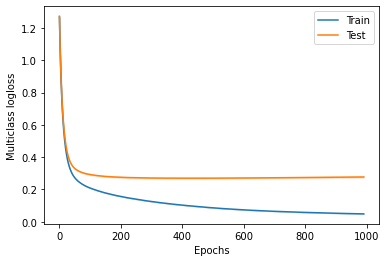

In [111]:
import seaborn as sns
sns.lineplot(data=training_history, x='Iteration', y='Training_mlogloss', label='Train')
sns.lineplot(data=training_history, x='Iteration', y='Test_mlogloss', label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')

plt.savefig('History_mlogloss.pdf')

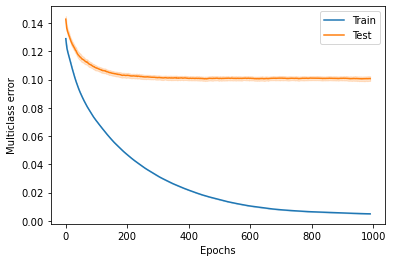

In [112]:
import seaborn as sns
sns.lineplot(data=training_history, x='Iteration', y='Training_merror', label='Train')
sns.lineplot(data=training_history, x='Iteration', y='Test_merror', label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass error')

plt.savefig('History_merror.pdf')

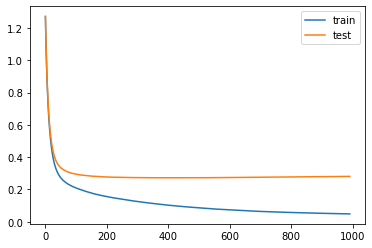

In [76]:
# plot learning curves
plt.plot(training_histories[1]['validation_0']['mlogloss'], label='train')
plt.plot(training_histories[1]['validation_1']['mlogloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [139]:
cm_labels = ["LERG", "HERG", "RQ", "SFG"]

## Performance for certain flags

In [171]:
for i, c in enumerate(['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']):
    print(i, c,np.nansum(y_train[c]))

0 Xray 478
1 Opt_spec 1277
2 IRAGN 4291
3 Donley 4614
4 XAGN 397
5 midIRAGN 205
6 VLBAAGN 178
7 RLAGN 936
8 optAGN 115


In [140]:
# Have to define own rounding function
def round_up(value, decimals):
    value = value * 10**decimals
    value = np.ceil(value)
    return value/10**decimals

First detection technique: optAGN with sample size: 115
Accuracy: 0.4


/var/lib/condor/execute/dir_2918266/ipykernel_2918699/1415814489.py:9: RuntimeWarning: invalid value encountered in true_divide
  cm_has_label1 = cm_has_label1/cm_has_label1.sum(axis=1)[:, np.newaxis]
/var/lib/condor/execute/dir_2918266/ipykernel_2918699/1415814489.py:11: RuntimeWarning: invalid value encountered in true_divide
  std_cm_has_label1 = detection_sources.iloc[:,i].to_numpy().std()/detection_sources.iloc[:,i].mean().sum(axis=1)[:, np.newaxis]


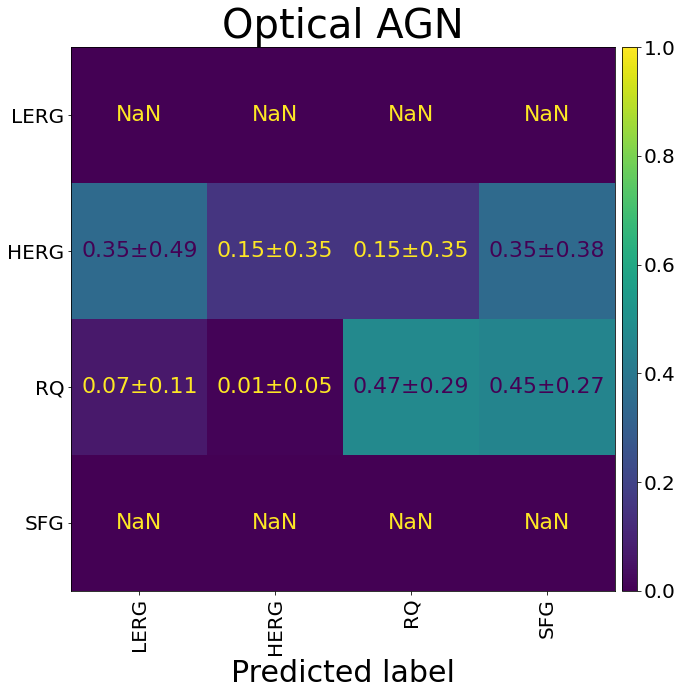

In [334]:
from matplotlib.colors import Normalize

# Can compare relative performance of 2 detection techniques
i = 8
print(f'First detection technique: {detection_sources.columns[i]} with sample size: {detection_sources.iloc[:,i].sum().sum()}')
print(f'Accuracy: {np.trace(detection_sources.sum(axis=0).iloc[i])/detection_sources.sum(axis=0).iloc[i].sum()}')

cm_has_label1 = detection_sources.sum(axis=0).iloc[i]
cm_has_label1 = cm_has_label1/cm_has_label1.sum(axis=1)[:, np.newaxis]

std_cm_has_label1 = detection_sources.iloc[:,i].to_numpy().std()/detection_sources.iloc[:,i].mean().sum(axis=1)[:, np.newaxis]

# Making the nan 0 so the colours work
cm_has_label1 = np.nan_to_num(cm_has_label1, nan=0)

fig, ax = plt.subplots(figsize=(10,10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_has_label1, display_labels=cm_labels, )
disp.plot(ax=ax, colorbar=False, )
disp.ax_.get_images()[0].set_clim(0, 1)


# Because sklearn is dumb we have to manually set the errors and such to 2 decimals this way
digits = 2
for k in range(4):
    for j in range(4):
        if cm_has_label1[k][j]>0:
            disp.text_[k][j].set_text(f'{np.round(cm_has_label1[k][j],digits):.{digits}f}±{round_up(std_cm_has_label1[k][j],digits):.{digits}f}')
            disp.text_[k][j].set_fontsize(22)
        else:
            disp.text_[k][j].set_text(f'NaN')
            disp.text_[k][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)
    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title(f"Optical AGN", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig(f"CM_{detection_sources.columns[i]}.pdf")
plt.show()

Overall accuracy: 0.8992931469413497 ± 0.003415184605774545

First non-detection technique: IRAGN with sample size: 4291
Accuracy without detection technique: 0.7932882777907247


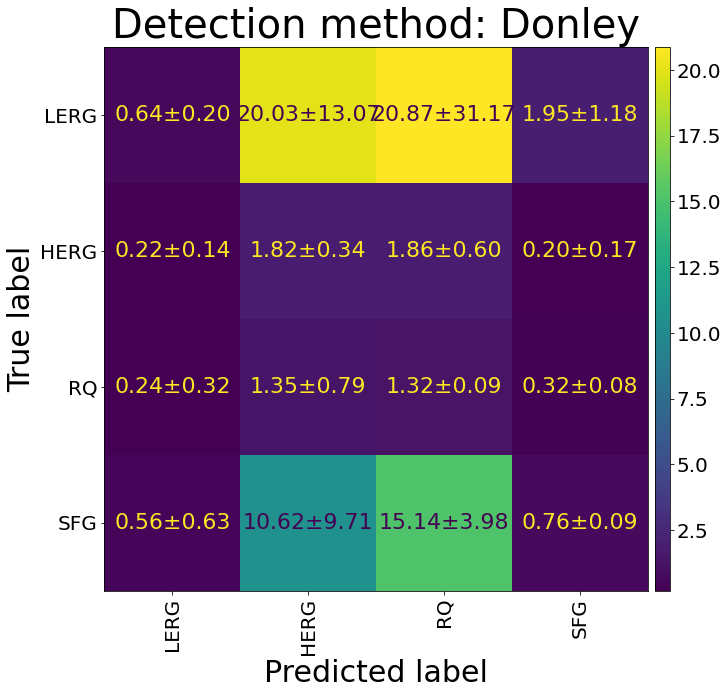


Quick explanation of plot: higher values means that in the Donley detected sources this square is higher


In [250]:
# Can compare relative performance of detection techniques with performance over all the data
i = 2

print(f"Overall accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")
print()
print(f'First non-detection technique: {detection_sources.columns[i]} with sample size: {detection_sources.iloc[:,i].sum().sum()}')
print(f'Accuracy without detection technique: {np.trace(detection_sources.sum(axis=0).iloc[i])/detection_sources.sum(axis=0).iloc[i].sum()}')

cm_has_label1 = detection_sources.sum(axis=0).iloc[i]
cm_has_label1 = cm_has_label1/cm_has_label1.sum(axis=1)[:, np.newaxis]

std_cm_has_label1 = detection_sources.iloc[:,i].to_numpy().std()/detection_sources.iloc[:,i].mean().sum(axis=1)[:, np.newaxis]
    
fig, ax = plt.subplots(figsize=(10,10))

# Error propagation
ratio = cm_has_label1/cm_norm_row

std = ratio * np.sqrt((std_cm_has_label1/cm_has_label1)**2 + (cm_norm_row_std/cm_norm_row)**2)

disp = ConfusionMatrixDisplay(confusion_matrix=ratio, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(ratio[i][j],digits):.{digits}f}±{round_up(std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)
        #disp.text_[i][j].set_c('grey')
        
print(f"\nQuick explanation of plot: higher values means that in the {detection_sources.columns[i]} detected sources this square is higher")

First non-detection technique: Xray with sample size: 61609
Accuracy: 0.9043159278676817


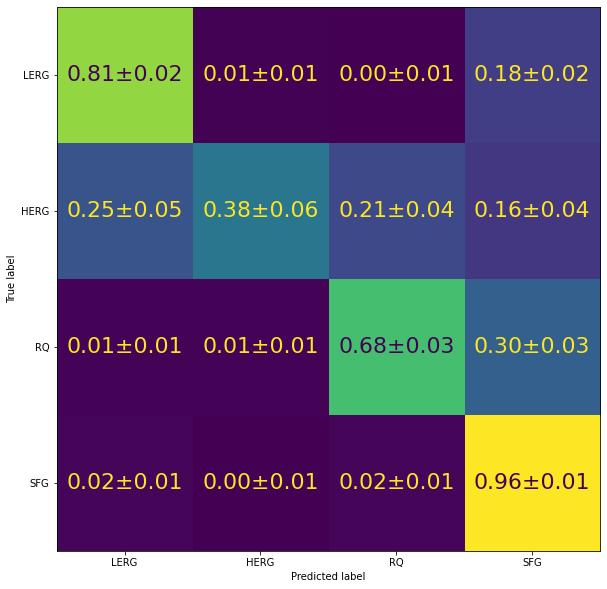

In [181]:
# Can compare relative performance of 2 non-detection techniques
i = 0
k = None

print(f'First non-detection technique: {non_detection_sources.columns[i]} with sample size: {non_detection_sources.iloc[:,i].sum().sum()}')
print(f'Accuracy: {np.trace(non_detection_sources.sum(axis=0).iloc[i])/non_detection_sources.sum(axis=0).iloc[i].sum()}')

cm_has_label1 = non_detection_sources.sum(axis=0).iloc[i]
cm_has_label1 = cm_has_label1/cm_has_label1.sum(axis=1)[:, np.newaxis]

std_cm_has_label1 = non_detection_sources.iloc[:,i].to_numpy().std()/non_detection_sources.iloc[:,i].mean().sum(axis=1)[:, np.newaxis]

if k!=None:
    print('---------------------------------------------')
    print(f'Second non-detection technique: {non_detection_sources.columns[k]} with sample size: {non_detection_sources.iloc[:,k].sum().sum()}')
    print(f'Accuracy: {np.trace(non_detection_sources.sum(axis=0).iloc[k])/non_detection_sources.sum(axis=0).iloc[k].sum()}')
    
    cm_has_label2 = non_detection_sources.sum(axis=0).iloc[k]
    cm_has_label2 = cm_has_label2/cm_has_label2.sum(axis=1)[:, np.newaxis]
    
    std_cm_has_label2 = non_detection_sources.iloc[:,k].to_numpy().std()/non_detection_sources.iloc[:,k].mean().sum(axis=1)[:, np.newaxis] 

    
fig, ax = plt.subplots(figsize=(10,10))
if k!=None:
    # Error propagation
    ratio = cm_has_label1/cm_has_label2
    
    std = ratio * np.sqrt((std_cm_has_label1/cm_has_label1)**2 + (std_cm_has_label2/cm_has_label2)**2)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=ratio, display_labels=cm_labels)
    disp.plot(ax=ax, colorbar=False)

    # Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
    digits = 2
    for i in range(4):
        for j in range(4):
            disp.text_[i][j].set_text(f'{np.round(ratio[i][j],digits):.{digits}f}±{round_up(std[i][j],digits):.{digits}f}')
            disp.text_[i][j].set_fontsize(22)
            #disp.text_[i][j].set_c('grey')
else:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_has_label1, display_labels=cm_labels)
    disp.plot(ax=ax, colorbar=False)

    # Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
    digits = 2
    for i in range(4):
        for j in range(4):
            disp.text_[i][j].set_text(f'{np.round(cm_has_label1[i][j],digits):.{digits}f}±{round_up(std_cm_has_label1[i][j],digits):.{digits}f}')
            disp.text_[i][j].set_fontsize(22)
            #disp.text_[i][j].set_c('grey')

Overall accuracy: 0.8992931469413497 ± 0.003415184605774545

First non-detection technique: Opt_spec with sample size: 60810
Accuracy without detection technique: 0.9051471797401743

Quick explanation of plot: higher values means that in the Donley detected sources this square is higher


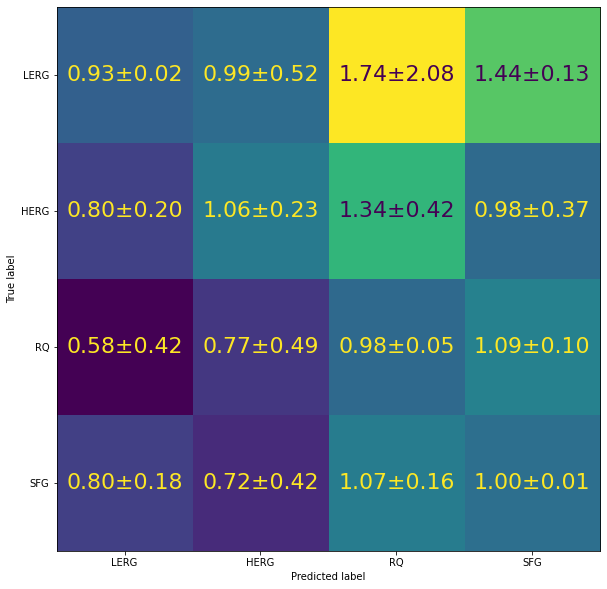

In [221]:
# Can compare relative performance of non-detection techniques with performance over all the data
i = 1

print(f"Overall accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")
print()
print(f'First non-detection technique: {non_detection_sources.columns[i]} with sample size: {non_detection_sources.iloc[:,i].sum().sum()}')
print(f'Accuracy without detection technique: {np.trace(non_detection_sources.sum(axis=0).iloc[i])/non_detection_sources.sum(axis=0).iloc[i].sum()}')

cm_has_label1 = non_detection_sources.sum(axis=0).iloc[i]
cm_has_label1 = cm_has_label1/cm_has_label1.sum(axis=1)[:, np.newaxis]

std_cm_has_label1 = non_detection_sources.iloc[:,i].to_numpy().std()/non_detection_sources.iloc[:,i].mean().sum(axis=1)[:, np.newaxis]
    
fig, ax = plt.subplots(figsize=(10,10))

# Error propagation
ratio = cm_has_label1/cm_norm_row

std = ratio * np.sqrt((std_cm_has_label1/cm_has_label1)**2 + (cm_norm_row_std/cm_norm_row)**2)

disp = ConfusionMatrixDisplay(confusion_matrix=ratio, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(ratio[i][j],digits):.{digits}f}±{round_up(std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)
        #disp.text_[i][j].set_c('grey')
        
print(f"\nQuick explanation of plot: higher values means that in the {non_detection_sources.columns[i]} detected sources this square is higher")

##### Complete dataset

In [113]:
precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
accuracies = np.array(accuracies)

In [114]:
precisions_means = np.mean(precisions, axis=0)
precisions_std = np.std(precisions, axis=0)

recalls_means = np.mean(recalls, axis=0)
recalls_std = np.std(recalls, axis=0)

f1s_means = np.mean(f1s, axis=0)
f1s_std = np.std(f1s, axis=0)

In [115]:
for i in range(4):
    print(f"{labels[i]}")
    print()
    print(f"Precision: {precisions_means[i]} ± {precisions_std[i]}")
    print(f"Recall: {recalls_means[i]} ± {recalls_std[i]}")
    print(f"F1-score: {f1s_means[i]} ± {f1s_std[i]}")
    print("--------------------------------------------------------------")
print(f"Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")

print(f"Macro average precision: {np.mean(precisions)} ± {np.std(precisions)}")
print(f"Macro average recall: {np.mean(recalls)} ± {np.std(recalls)}")
print(f"Macro average F1: {np.mean(f1s)} ± {np.std(f1s)}")

jet-mode radio AGN/low-excitation radio galaxy

Precision: 0.8971263095593583 ± 0.00919963001094687
Recall: 0.8645108297594856 ± 0.006518005726126884
F1-score: 0.8804699003725893 ± 0.004602507916137433
--------------------------------------------------------------
quasar-like radio AGN / high-excitation radio galaxy

Precision: 0.628630212766089 ± 0.05238489569566901
Recall: 0.33071578145821434 ± 0.030285736227410015
F1-score: 0.43246726174713057 ± 0.03338367881273119
--------------------------------------------------------------
radio-quiet AGN

Precision: 0.7807129513972116 ± 0.020321163453103898
Recall: 0.6674096114553772 ± 0.01842431612970129
F1-score: 0.7194559049287911 ± 0.01579435829207093
--------------------------------------------------------------
star-forming galaxy

Precision: 0.9160065546142876 ± 0.003679691075986565
Recall: 0.9582142969818851 ± 0.0042634306803965025
F1-score: 0.936626303705522 ± 0.0027277833291023445
------------------------------------------------------

In [338]:
def error_in_sum(stds):
    return np.sqrt(sum(stds**2))

ratio = np.unique(y_train['Classification'], return_counts=True)[1] 
ratio = ratio/sum(ratio)

print(f"Weighted average precision: {sum(ratio*precisions_means)} ± {error_in_sum(ratio*precisions_std)}")
print(f"Weighted average recall: {sum(ratio*recalls_means)} ± {error_in_sum(ratio*recalls_std)}")
print(f"Weighted average F1: {sum(ratio*f1s_means)} ± {error_in_sum(ratio*f1s_std)}")

Weighted average precision: 0.8947872022531289 ± 0.003828856898385791
Weighted average recall: 0.8992932080229818 ± 0.0035783050437050204
Weighted average F1: 0.8952643429023235 ± 0.0025424984456288656


In [339]:
precisions_std

array([0.00919963, 0.0523849 , 0.02032116, 0.00367969])

##### Per dataset

In [340]:
dat = scores_subgroups[scores_subgroups['Source'] == 'Original']
np.std(dat.Precision.to_numpy())

array([0.0130197 , 0.08034292, 0.0204329 , 0.0037897 ])

In [341]:
for source in ['Original', 'BH', 'MIGHTEE']:
    # Just selecting the source
    dat = scores_subgroups[scores_subgroups['Source'] == source]
    
    precisions_means = np.mean(dat.Precision.to_numpy(), axis=0)
    precisions_std = np.std(dat.Precision.to_numpy(), axis=0)

    recalls_means = np.mean(dat.Recall.to_numpy(), axis=0)
    recalls_std = np.std(dat.Recall.to_numpy(), axis=0)

    f1s_means = np.mean(dat.F1.to_numpy(), axis=0)
    f1s_std = np.std(dat.F1.to_numpy(), axis=0)
    
    print(source)
    for i in range(4):
        print(f"{labels[i]}")
        print()
        print(f"Precision: {precisions_means[i]} ± {precisions_std[i]}")
        print(f"Recall: {recalls_means[i]} ± {recalls_std[i]}")
        print(f"F1-score: {f1s_means[i]} ± {f1s_std[i]}")
        print("--------------------------------------------------------------")
    print(f"Accuracy: {np.mean(dat['Accuracy'])} ± {np.std(dat['Accuracy'])}")

    # I hate storing lists in dataframes
    precisions_grouped = np.array(list(dat.Precision.to_numpy()))
    recalls_grouped = np.array(list(dat.Recall.to_numpy()))
    f1s_grouped = np.array(list(dat.F1.to_numpy()))
    
    # Finding the total ratio by taking the average
    ratio = dat.Ratio.apply(lambda x: x.sort_index())
    ratio = ratio.div(ratio.sum(axis=1), axis=0)
    ratio = ratio.sum(axis=0)/len(ratio)
    
    # For BH we need to ignore the 3rd column, since that doesn't have RQ
    if source != 'BH':
        print(f"Macro average precision: {np.mean(precisions_grouped)} ± {np.std(precisions_grouped)}")
        print(f"Macro average recall: {np.mean(recalls_grouped)} ± {np.std(recalls_grouped)}")
        print(f"Macro average F1: {np.mean(f1s_grouped)} ± {np.std(f1s_grouped)}")

        print(f"Weighted average precision: {sum(ratio*precisions_means)} ± {error_in_sum(ratio*precisions_std)}")
        print(f"Weighted average recall: {sum(ratio*recalls_means)} ± {error_in_sum(ratio*recalls_std)}")
        print(f"Weighted average F1: {sum(ratio*f1s_means)} ± {error_in_sum(ratio*f1s_std)}")
    else:
        print(f"Macro average precision: {np.mean(precisions_grouped[:,[0,1,3]])} ± {np.std(precisions_grouped[:,[0,1,3]])}")
        print(f"Macro average recall: {np.mean(recalls_grouped[:,[0,1,3]])} ± {np.std(recalls_grouped[:,[0,1,3]])}")
        print(f"Macro average F1: {np.mean(f1s_grouped[:,[0,1,3]])} ± {np.std(f1s_grouped[:,[0,1,3]])}")

        print(f"Weighted average precision: {sum(ratio*precisions_means[[0,1,3]])} ± {error_in_sum(ratio*precisions_std[[0,1,3]])}")
        print(f"Weighted average recall: {sum(ratio*recalls_means[[0,1,3]])} ± {error_in_sum(ratio*recalls_std[[0,1,3]])}")
        print(f"Weighted average F1: {sum(ratio*f1s_means[[0,1,3]])} ± {error_in_sum(ratio*f1s_std[[0,1,3]])}")
    print("------------------------------------------------------------------------------------")

Original
jet-mode radio AGN/low-excitation radio galaxy

Precision: 0.8725073776718762 ± 0.01301969957744755
Recall: 0.807889022571514 ± 0.01470271783055476
F1-score: 0.8388746055634746 ± 0.011368638549890975
--------------------------------------------------------------
quasar-like radio AGN / high-excitation radio galaxy

Precision: 0.6598430886798878 ± 0.08034292232854964
Recall: 0.3781235866123926 ± 0.04712975892924783
F1-score: 0.47917144024136754 ± 0.05281707177180557
--------------------------------------------------------------
radio-quiet AGN

Precision: 0.7840777713877272 ± 0.020432896761869452
Recall: 0.6852127686622822 ± 0.018993817100126407
F1-score: 0.7311579378662043 ± 0.016427458621072796
--------------------------------------------------------------
star-forming galaxy

Precision: 0.9238193446161229 ± 0.0037897011346204696
Recall: 0.9624823446327684 ± 0.00394687304133267
F1-score: 0.9427482887601045 ± 0.003001243997784245
-----------------------------------------------

##### Confusion matrices

In [342]:
# Have to define own rounding function
def round_up(value, decimals):
    value = value * 10**decimals
    value = np.ceil(value)
    return value/10**decimals

In [343]:
cm_labels = ["LERG", "HERG", "RQ", "SFG"]

In [344]:
print(f'{np.round(cm_norm_row[i][j],4):.4f}')

0.9582


In [345]:
cm_norm_row_std[0][0]

0.006505318399316829

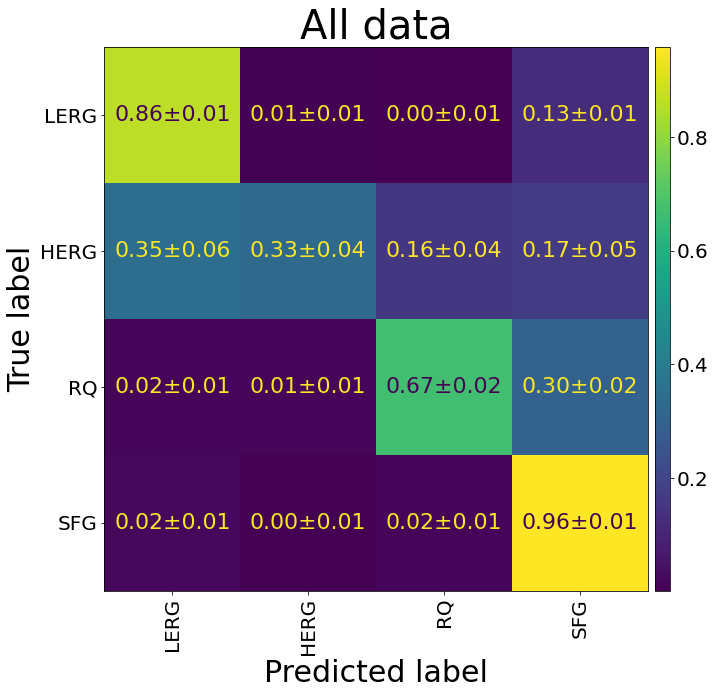

In [346]:
# Calculating the cm
cm_norm_row = np.array(cm_all).mean(axis=0)/np.array(cm_all).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_all).std(axis=0)/np.array(cm_all).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("All data", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('True label', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_all.pdf")
plt.show()

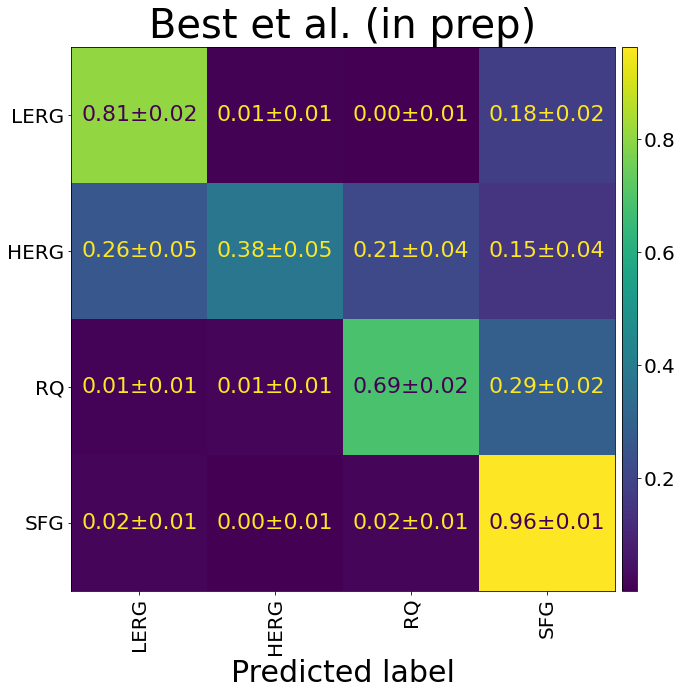

In [347]:
# Calculating the cm
cm_norm_row = np.array(cm_original).mean(axis=0)/np.array(cm_original).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_original).std(axis=0)/np.array(cm_original).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("Best et al. (in prep)", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_original.pdf")
plt.show()

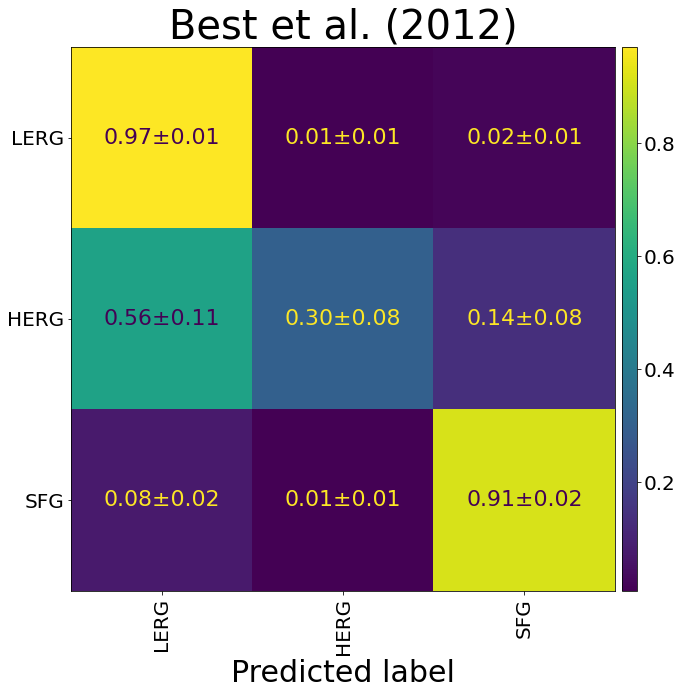

In [348]:
## Calculating the cm
cm_norm_row = np.array(cm_BH).mean(axis=0)/np.array(cm_BH).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_BH).std(axis=0)/np.array(cm_BH).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=['LERG', 'HERG', 'SFG'])
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(3):
    for j in range(3):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("Best et al. (2012)", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_BH.pdf")
plt.show()

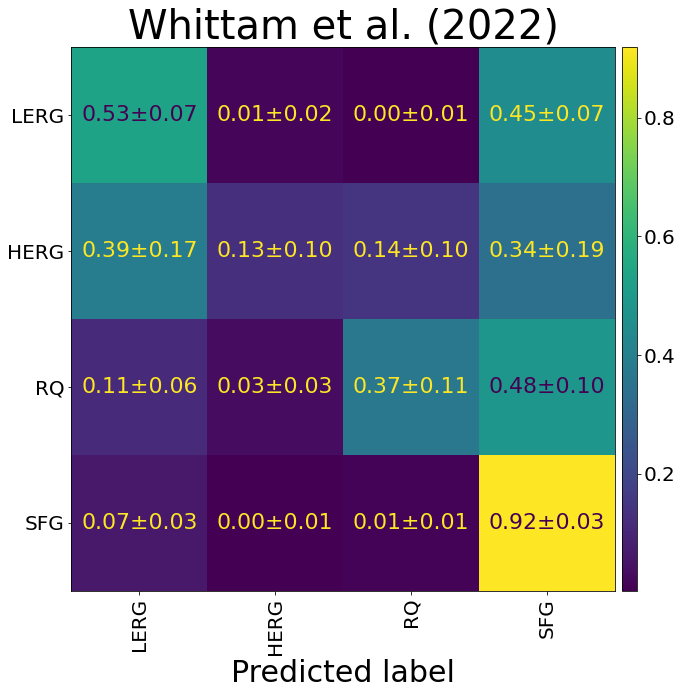

In [349]:
# Calculating the cm
cm_norm_row = np.array(cm_MIGHTEE).mean(axis=0)/np.array(cm_MIGHTEE).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_MIGHTEE).std(axis=0)/np.array(cm_MIGHTEE).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)
    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("Whittam et al. (2022)", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_MIGHTEE.pdf")
plt.show()

## SHAP

In [116]:
import shap
shap.initjs()

In [117]:
mapping = {'Total_flux': 'Total 150 MHz',
           'Peak_flux': 'Peak 150 MHz', 
           'NUV_flux_corr': 'NUV', 
           'u_flux_corr': 'u',
           'Bw_flux_corr': r'$B_w$', 
           'R_flux_corr': 'R', 
           'I_flux_corr': 'I', 
           'z_flux_corr': 'z',
           'y_flux_corr': 'y', 
           'J_flux_corr': 'J', 
           'H_flux_corr': 'H', 
           'K_flux_corr': 'K',
           'Ks_flux_corr': r'$K_s$', 
           'ch1_flux_corr': 'ch1', 
           'ch2_flux_corr': 'ch2', 
           'ch3_flux_corr': 'ch3',
           'ch4_flux_corr': 'ch4', 
           'F_MIPS_24': 'MIPS24', 
           'F_PACS_100': 'PACS100', 
           'F_PACS_160': 'PACS160', 
           'F_SPIRE_250': 'SPIRE250',
           'F_SPIRE_350': 'SPIRE350', 
           'F_SPIRE_500': 'SPIRE500', 
           'Z_BEST': 'Redshift', 
           'g_flux_corr': 'g',
           'nb921_hsc_flux_corr': 'NB921'}

In [118]:
shap_values = shap.TreeExplainer(model, check_additivity=False).shap_values(X_train, check_additivity=False)

In [119]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22, "axes.labelsize": 200})

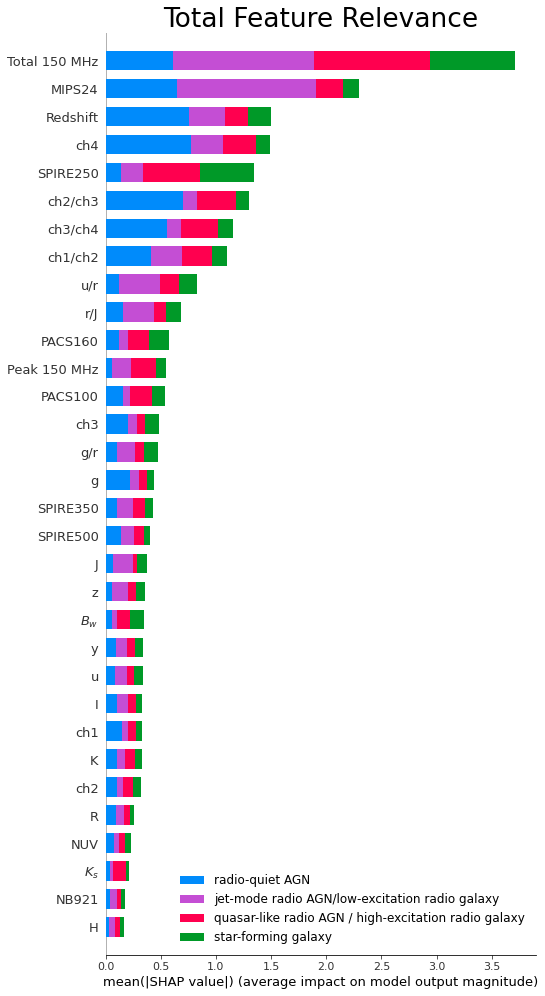

In [120]:
shap.summary_plot(shap_values, X_train.rename(columns=mapping), class_names=labels, max_display=999, show=False)
plt.title("Total Feature Relevance")
plt.tight_layout()
plt.savefig("Total_feature_relevance.pdf")

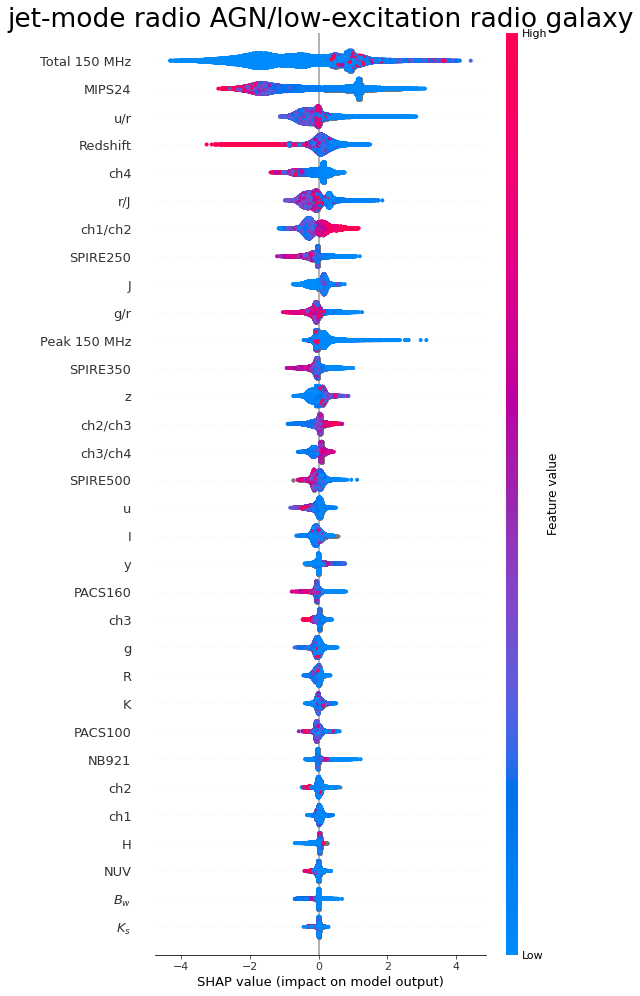

In [121]:
shap.summary_plot(shap_values[0], X_train.rename(columns=mapping), show=False, max_display=999)
plt.title(labels[0])
plt.tight_layout()
plt.savefig("LERG_relevance.pdf")
plt.show()

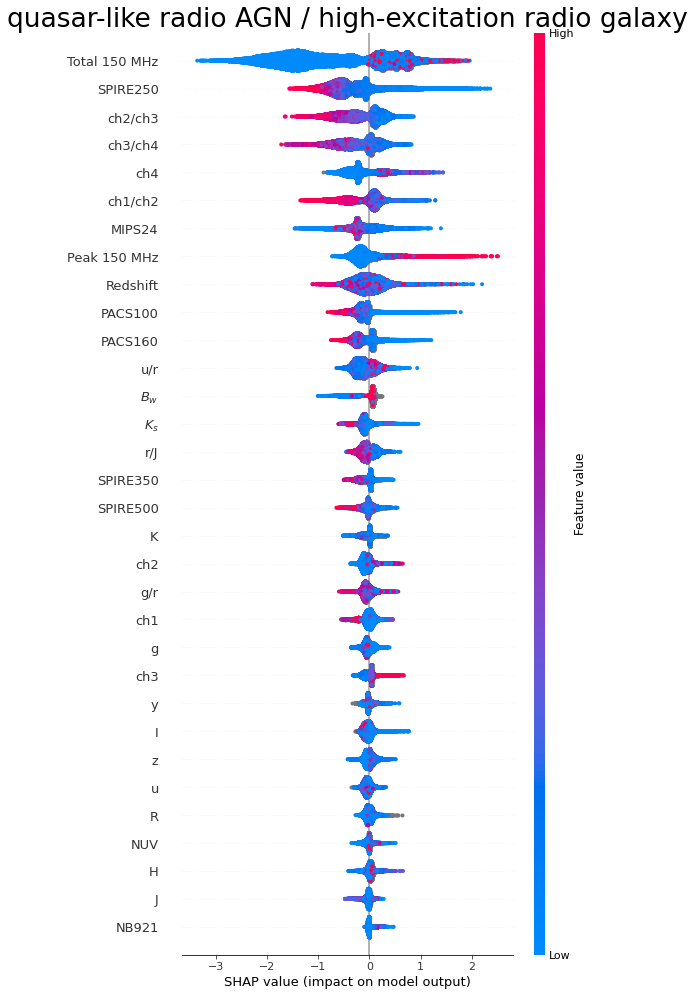

In [122]:
shap.summary_plot(shap_values[1], X_train.rename(columns=mapping), show=False, max_display=999)
plt.title(labels[1])
plt.tight_layout()
plt.savefig("HERG_relevance.pdf")
plt.show()

In [ ]:
shap.summary_plot(shap_values[2], X_train.rename(columns=mapping).rename(columns=mapping), show=False, max_display=999)
plt.title(labels[2])
plt.tight_layout()
plt.savefig("RQ_relevance.pdf")
plt.show()

In [ ]:
shap.summary_plot(shap_values[3], X_train.rename(columns=mapping).rename(columns=mapping), show=False, max_display=999)
plt.title(labels[3])
plt.tight_layout()
plt.savefig("SFG_relevance.pdf")
plt.show()